<a href="https://colab.research.google.com/github/nchelaru/SQL-learnr/blob/master/collinearity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [3]:
install.packages(c('faraway', 'olsrr', 'corrplot', 'car'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘zip’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘gower’, ‘ipred’, ‘timeDate’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘data.table’, ‘openxlsx’, ‘lme4’, ‘checkmate’, ‘goftest’, ‘gridExtra’, ‘nortest’, ‘recipes’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’




# Import data

In [0]:
house <- read.csv('https://github.com/nchelaru/practical_statistics/raw/master/Data/kc_house_data.csv')

house$date <- as.Date(house$date,  "%Y%m%dT000000")

# Visualize data

corrplot 0.84 loaded



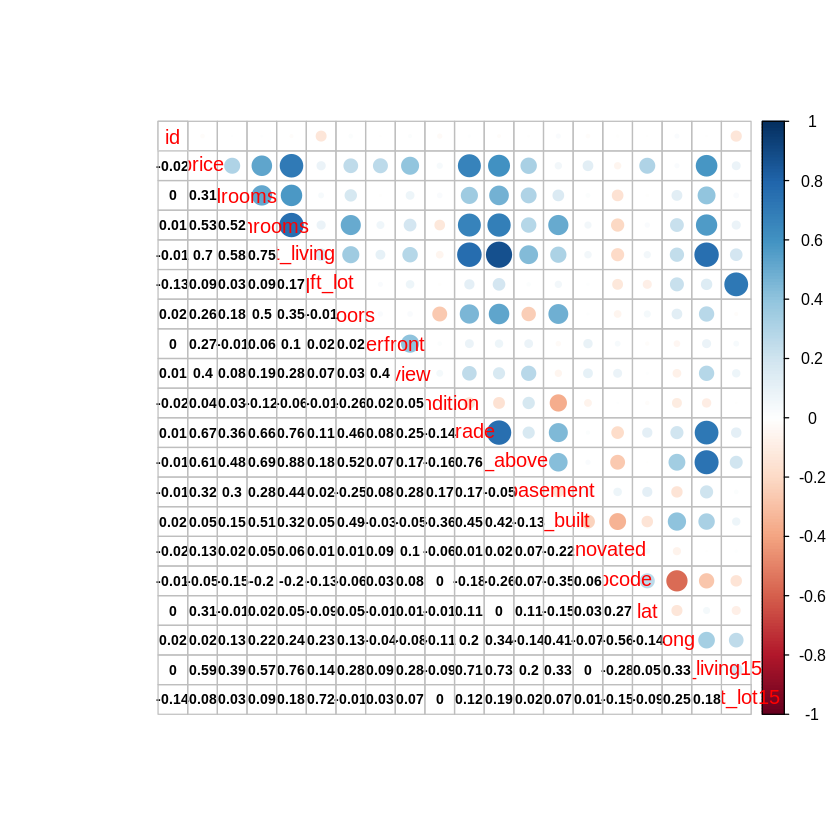

In [5]:
library(corrplot)

cor1 = cor(within(house, rm('date')))

corrplot.mixed(cor1, lower.col='black', number.cex = .7)

# Build model

In [6]:
alias(lm(price ~ .,
          data=house,
          na.action=na.omit))

Model :
price ~ id + date + bedrooms + bathrooms + sqft_living + sqft_lot + 
    floors + waterfront + view + condition + grade + sqft_above + 
    sqft_basement + yr_built + yr_renovated + zipcode + lat + 
    long + sqft_living15 + sqft_lot15

Complete :
              (Intercept) id date bedrooms bathrooms sqft_living sqft_lot
sqft_basement  0           0  0    0        0         1           0      
              floors waterfront view condition grade sqft_above yr_built
sqft_basement  0      0          0    0         0    -1          0      
              yr_renovated zipcode lat long sqft_living15 sqft_lot15
sqft_basement  0            0       0   0    0             0        


In [7]:
alias(lm(price ~ . -sqft_basement,
          data=house,
          na.action=na.omit))

Model :
price ~ (id + date + bedrooms + bathrooms + sqft_living + sqft_lot + 
    floors + waterfront + view + condition + grade + sqft_above + 
    sqft_basement + yr_built + yr_renovated + zipcode + lat + 
    long + sqft_living15 + sqft_lot15) - sqft_basement


In [0]:
house_lm <- lm(price ~ . -sqft_basement,
               data=house, 
               na.action=na.omit)

# Quantify collinearity by Variance Inflation Factor (VIF)

The variance inflation factor quantifies the effect of collinearity on the variance of our regression estimates.

## `faraway` package

From "[Applied Statistics with R](https://daviddalpiaz.github.io/appliedstats/collinearity.html#collinearity-1)": in practice, VIF > 5 is cause for concern.

In [0]:
library(faraway)

df_faraway <- as.data.frame(vif(house_lm))

df_faraway$Variables <- row.names(df_faraway)

## `car` package

In [0]:
df_car <- as.data.frame(car::vif(house_lm))

df_car$Variables <- row.names(df_car)

## `olsrr` package

From `olsrr` [vignettes](https://cran.r-project.org/web/packages/olsrr/vignettes/regression_diagnostics.html):
* A VIF of 1 means that there is no correlation among the kth predictor and the  remaining predictor variables, and hence the variance of βk is not inflated at all. 
* The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction.

In [32]:
library(olsrr)

df_olsrr <- as.data.frame(ols_vif_tol(house_lm))

head(df_olsrr)

,Variables,Tolerance,VIF
,<chr>,<dbl>,<dbl>
1,id,0.9725439,1.028231
2,date,0.9926553,1.007399
3,bedrooms,0.6052800,1.652128
4,bathrooms,0.2984207,3.350974
5,sqft_living,0.1155156,8.656836
6,sqft_lot,0.4742749,2.108482


In [0]:
library(plyr)
library(dplyr)

df <- join_all(list(df_faraway, df_olsrr[, c('Variables', 'VIF')], df_car), by = 'Variables', type = 'full')
 

In [0]:
row.names(df) <- df$Variables

In [41]:
head(df)

,vif(house_lm),Variables,VIF,car::vif(house_lm)
,<dbl>,<chr>,<dbl>,<dbl>
id,1.028231,id,1.028231,1.028231
date,1.007399,date,1.007399,1.007399
bedrooms,1.652128,bedrooms,1.652128,1.652128
bathrooms,3.350974,bathrooms,3.350974,3.350974
sqft_living,8.656836,sqft_living,8.656836,8.656836
sqft_lot,2.108482,sqft_lot,2.108482,2.108482


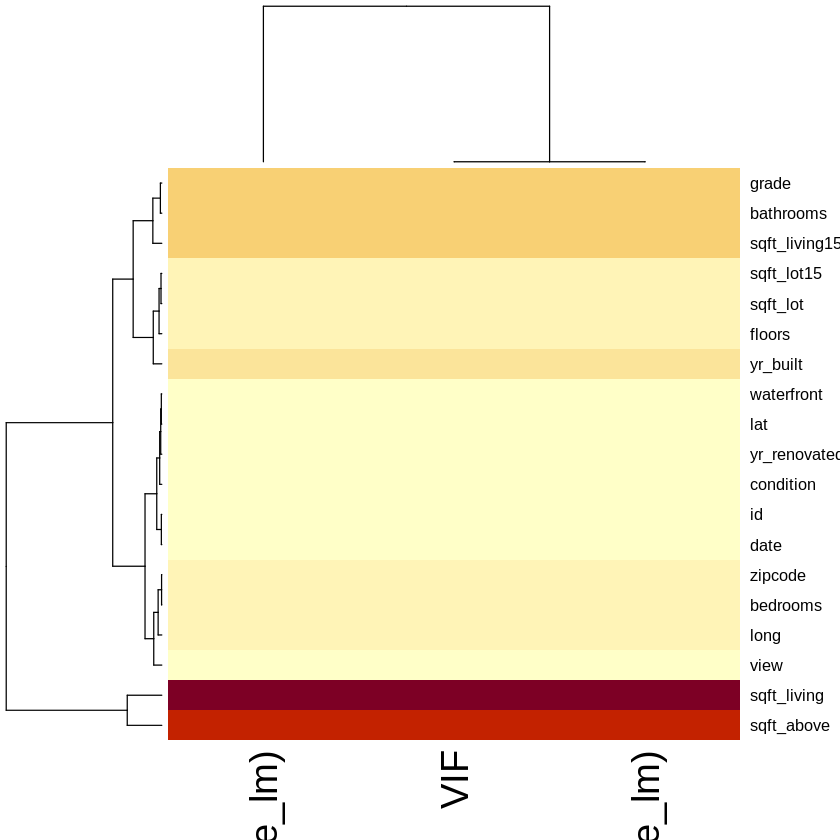

In [47]:
heatmap(as.matrix(within(df, rm('Variables'))), scale='column')